In [4]:
!pip install tensorflow-gpu==2.7.0 opencv-python tensorflow_datasets matplotlib pycocotools numpy;

^C


In [19]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import tensorflow_datasets as tfds
import datetime
from coco import COCO
from coco_labels_paper import labels as coco_labels
import shutil
from tensorflow.keras.utils import to_categorical
import matplotlib as plt
from tensorflow import keras
from keras import backend as K
import random

In [12]:
resnet50 = keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))
resnet50.summary()
resnet50.trainable = False

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [13]:
def euclidean_distance(vectors):
    (features_A, features_B) = vectors
    sum_squared = K.sum(K.square(features_A - features_B), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [86]:
input_a = Input(shape=(224,224,3))
input_b = Input(shape=(224,224,3))

features_a = resnet50(input_a)
features_b = resnet50(input_b)

distance = Lambda(euclidean_distance)([features_a, features_b])
distance = Flatten()(distance)
distance = Dense(1024, activation="relu")(distance)
distance = Dense(1024, activation="relu")(distance)
output = Dense(1, activation="sigmoid")(distance)
siamese_model = Model(inputs=[input_a, input_b], outputs=output)

siamese_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_24 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['input_23[0][0]',               
                                                                  'input_24[0][0]']         

In [87]:
available_files = {}
for d in os.listdir("data/coco_onehot_data"):
    files = os.listdir(f"data/coco_onehot_data/{d}")
    if len(files) > 0:
        available_files[d] = files

print(len(available_files))

80


In [88]:
def get_training_data(epoch_size=1024):
    X_a = []
    X_b = []
    Y = []
    available_classes = list(available_files.keys())

    for i in range(int(epoch_size/2)):

        c = random.choice(available_classes)
        n = random.choice([d for d in available_classes if d is not c])
        anchor = random.choice(available_files[c])
        positive = random.choice(available_files[c])
        negative = random.choice(available_files[n])

        X_a.append(f"data/coco_onehot_data/{c}/{anchor}")
        X_a.append(f"data/coco_onehot_data/{c}/{anchor}")
        X_b.append(f"data/coco_onehot_data/{c}/{positive}")
        X_b.append(f"data/coco_onehot_data/{n}/{negative}")
        Y.append(1)
        Y.append(0)

    return (X_a, X_b, Y)
        

In [73]:
dasd = get_training_data()
# random.choice(os.listdir("data/coco_onehot_data/airplane"))
print(len(dasd[0]))

1024


In [89]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)
siamese_model.compile(loss=binary_cross_loss, optimizer=opt, metrics=METRICS)

def load_images(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img = img/255.0
    return img

def preprocess_twins(anchor, validation, label):
    return ((load_images(anchor), load_images(validation)), label)

In [90]:
for e in range(1):
    data = get_training_data(2**16)
    a = tf.data.Dataset.from_tensor_slices(data[0])
    b = tf.data.Dataset.from_tensor_slices(data[1])
    y = tf.data.Dataset.from_tensor_slices(data[2])
    final_data = tf.data.Dataset.zip((a,b,y))
    processed_data = final_data.map(preprocess_twins)
    processed_data = processed_data.batch(32)
    processed_data = processed_data.prefetch(8)
    #print(len(data[2]))
    loss = siamese_model.fit(processed_data, batch_size=32, epochs=10)
    print(loss)

Epoch 1/10
2048/2048 [==============================] - 499s 238ms/step - loss: 0.6899 - tp: 18415.0000 - fp: 15879.0000 - tn: 16889.0000 - fn: 14353.0000 - accuracy: 0.5387 - precision: 0.5370 - recall: 0.5620 - auc: 0.5533 - prc: 0.5409
Epoch 2/10
2048/2048 [==============================] - 493s 241ms/step - loss: 0.6817 - tp: 19552.0000 - fp: 15589.0000 - tn: 17179.0000 - fn: 13216.0000 - accuracy: 0.5605 - precision: 0.5564 - recall: 0.5967 - auc: 0.5845 - prc: 0.5735
Epoch 3/10
2048/2048 [==============================] - 499s 244ms/step - loss: 0.6762 - tp: 19722.0000 - fp: 14972.0000 - tn: 17796.0000 - fn: 13046.0000 - accuracy: 0.5725 - precision: 0.5685 - recall: 0.6019 - auc: 0.6016 - prc: 0.5911
Epoch 4/10
2048/2048 [==============================] - 492s 240ms/step - loss: 0.6717 - tp: 19638.0000 - fp: 14533.0000 - tn: 18235.0000 - fn: 13130.0000 - accuracy: 0.5779 - precision: 0.5747 - recall: 0.5993 - auc: 0.6126 - prc: 0.6045
Epoch 5/10
2048/2048 [======================

In [91]:
siamese_model.save_weights(os.path.join("weights/siamese_pretrained", "model"))

tf.Tensor([1], shape=(1,), dtype=int32)


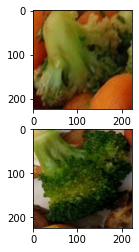

In [152]:
data = get_training_data(2)
a = tf.data.Dataset.from_tensor_slices(data[0])
b = tf.data.Dataset.from_tensor_slices(data[1])
y = tf.data.Dataset.from_tensor_slices(data[2])
final_data = tf.data.Dataset.zip((a,b,y))
processed_data = final_data.map(preprocess_twins)
processed_data = processed_data.batch(1)
processed_data = processed_data.prefetch(1)

img_batch = next(iter(processed_data))

#plt.pyplot.imshow(img_batch[0][0][0])
fig, axs = plt.pyplot.subplots(2,1)
axs[0].imshow(img_batch[0][0][0])
axs[1].imshow(img_batch[0][1][0])
print(img_batch[1])

In [153]:
siamese_model.predict(img_batch[0])

array([[0.63003224]], dtype=float32)